## CNN 

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing import image 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score


Using TensorFlow backend.


In [2]:
def get_image_value(path): 
    img = image.load_img(path, target_size = (224,224,3))
    img = image.img_to_array(img)
    return img/255

In [3]:
def get_conv_model_normal():
    
    inp_shape = (224,224,3)
    act = 'relu'
    drop = .5 
    kernal_reg = regularizers.l1(.001)
    dil_rate = 2
    
    
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
    model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (2,2)))
    
    
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))
    

    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

    
    model.add(Flatten())

    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))


    model.add(Dropout(drop))

    model.add(Dense(1, activation='sigmoid', name = 'Output_Layer'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model 


In [4]:
train_type = 'Normal'

def get_samples_norm(): 
    x_train = pickle.load(open(f'../Pickles/x_train.p', 'rb'))
    x_test = pickle.load(open(f'../Pickles/x_test.p', 'rb'))
    y_train = pickle.load(open(f'../Pickles/y_train.p', 'rb'))
    y_test = pickle.load(open(f'../Pickles/y_test.p', 'rb'))
    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = get_samples_norm()


In [5]:
type(y_test)

pandas.core.frame.DataFrame

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
augmentation =ImageDataGenerator(rotation_range = 15, width_shift_range = .1, height_shift_range = .1, 
                                                           horizontal_flip = True, fill_mode = 'nearest')
augmentation.fit(x_train)


early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .002)
model_checkpoint = ModelCheckpoint('models/CNN-ModelCheckpointWeights.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 3, mode = 'min')
epochs = 50
batch_size = 16
normal_model = get_conv_model_normal()
normal_history = normal_model.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
                epochs = epochs, 
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Epoch 1/50
11/11 [==============================] - 31s 3s/step - loss: 11.6194 - acc: 0.6532 - val_loss: 10.2057 - val_acc: 0.6364

Epoch 00001: val_loss improved from inf to 10.20570, saving model to models/CNN-ModelCheckpointWeights.h5
Epoch 2/50
11/11 [==============================] - 7s 639ms/step - loss: 9.4701 - acc: 0.6953 - val_loss: 8.5919 - val_acc: 0.7273

Epoch 00002: val_loss improved from 10.20570 to 8.59193, saving model to models/CNN-ModelCheckpointWeights.h5
Epoch 3/50
11/11 [==============================] - 4s 318ms/step - loss: 7.9223 - acc: 0.6554 - val_loss: 7.1400 - val_acc: 0.7273

Epoch 00003: val_loss improved from 8.59193 to 7.14000, saving model to models/CNN-ModelCheckpointWeights.h5
Epoch 4/50
11/11 [==============================] - 4s 319ms/step - loss: 6.6066 - acc: 0.6795 - val_loss: 5.9572 - val_acc: 0.6591

Epoch 00004: val_loss improved from 7.14000 to 5.95718, saving model to models/CNN-ModelCheckpointWeights.h5
Epoch 5/50
11/11 [================

11/11 [==============================] - 3s 317ms/step - loss: 1.0264 - acc: 0.8730 - val_loss: 1.0691 - val_acc: 0.8864

Epoch 00036: val_loss did not improve from 0.99514
Epoch 37/50
11/11 [==============================] - 3s 317ms/step - loss: 0.9845 - acc: 0.8827 - val_loss: 0.9428 - val_acc: 0.9091

Epoch 00037: val_loss improved from 0.99514 to 0.94277, saving model to models/CNN-ModelCheckpointWeights.h5
Epoch 38/50
11/11 [==============================] - 3s 318ms/step - loss: 0.9851 - acc: 0.8923 - val_loss: 0.9502 - val_acc: 0.9091

Epoch 00038: val_loss did not improve from 0.94277
Epoch 39/50
11/11 [==============================] - 3s 317ms/step - loss: 0.8971 - acc: 0.9146 - val_loss: 0.9711 - val_acc: 0.8864

Epoch 00039: val_loss did not improve from 0.94277
Epoch 40/50
11/11 [==============================] - 3s 318ms/step - loss: 0.9272 - acc: 0.9203 - val_loss: 0.9450 - val_acc: 0.8864

Epoch 00040: val_loss did not improve from 0.94277
Epoch 41/50
11/11 [==========

In [7]:
print(normal_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Conv2D)         (None, 224, 224, 64)      1792      
_________________________________________________________________
dense_1 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
dense_2 (Dense)              (None, 112, 112, 64)      4160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
__________

## Loss & Accuracy

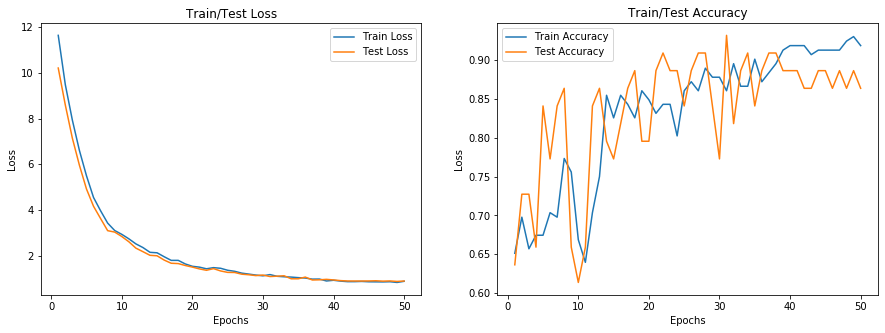

In [8]:
train_loss = normal_history.history['loss']
train_acc = normal_history.history['acc']
test_loss = normal_history.history['val_loss']
test_acc = normal_history.history['val_acc']
epochs = [i for i in range(1, len(test_acc)+1)]

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(epochs, train_loss, label = 'Train Loss')
ax[0].plot(epochs, test_loss, label = 'Test Loss')
ax[0].set_title('Train/Test Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, train_acc, label = 'Train Accuracy')
ax[1].plot(epochs, test_acc, label = 'Test Accuracy')
ax[1].set_title('Train/Test Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

In [9]:
y_test.shape

(44, 1)

### AUC and ROC Curves

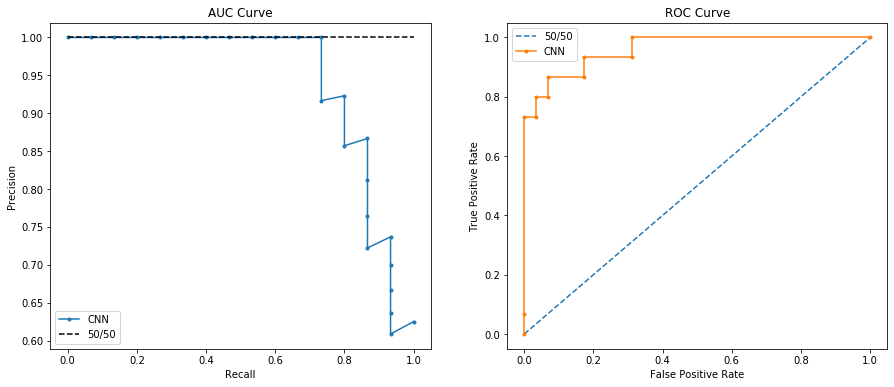

,F1 Score,AUC,ROC
0,0.828,0.942,0.961


In [10]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
normal_model = get_conv_model_normal()
normal_model.load_weights('models/CNN-ModelCheckpointWeights.h5') #load the best weights before overfitting
 

fig, ax = plt.subplots(1,2, figsize = (15,6))
#AUC CURVE
y_test_prob = normal_model.predict(x_test)

y_test_precision, y_test_recall, spec = precision_recall_curve(y_test, y_test_prob)
y_test_predict = np.where(y_test_prob >= .5, 1, 0).ravel()
y_test_f1= f1_score(y_test, y_test_predict)
y_test_auc = auc(y_test_recall, y_test_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
ax[0].plot(y_test_recall, y_test_precision, marker='.', label='CNN')
ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='50/50', color = 'Black')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title(f'AUC Curve')
ax[0].legend()

#ROC CURVE
ns_probs = [0 for i in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
y_test_roc = roc_auc_score(y_test, y_test_prob)

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
y_test_fpr, y_test_tpr, threshold = roc_curve(y_test, y_test_prob)
ax[1].plot(ns_fpr, ns_tpr, linestyle='--', label='50/50')
ax[1].plot(y_test_fpr, y_test_tpr, marker='.', label='CNN')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title(f'ROC Curve')
ax[1].legend()
plt.show()

pd.DataFrame({'F1 Score': round(y_test_f1, 3), 'AUC': round(y_test_auc, 3), 'ROC':round(y_test_roc, 3)}, index = [0])

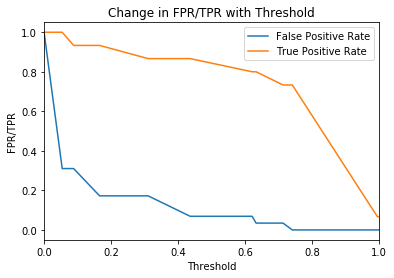

In [11]:
df = pd.DataFrame({'Threshold': threshold, 'FPR': y_test_fpr, 'TPR': y_test_tpr})
plt.plot(df.Threshold, df.FPR, label = 'False Positive Rate')
plt.plot(df.Threshold, df.TPR, label = 'True Positive Rate')
plt.xlabel('Threshold')
plt.ylabel('FPR/TPR')
plt.title('Change in FPR/TPR with Threshold')
plt.xlim(0, 1)
plt.legend()
plt.show()

### Confusion Matrix

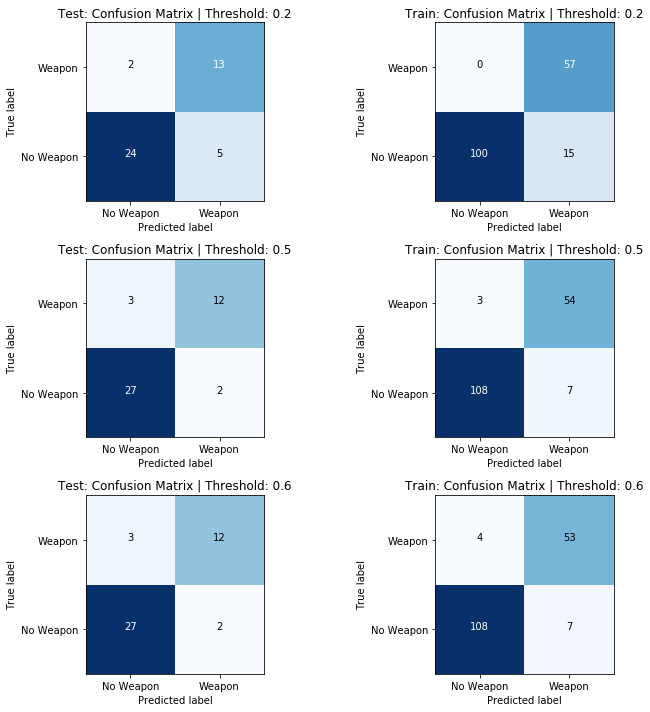

In [12]:
import itertools
import seaborn as sns
def plot_confusion_matrix(y_test,y_train, y_train_prob, y_test_prob,thresholds, classes,
                          cmap=plt.cm.Blues):
    fig, ax = plt.subplots(len(thresholds),2, figsize = (10,10))

    for idx, thresh in enumerate(thresholds):
        y_test_predict = np.where(y_test_prob >= thresh, 1, 0)
        y_train_predict = np.where(y_train_prob >= thresh, 1, 0)
        train_cm = confusion_matrix(y_train, y_train_predict) 
        test_cm = confusion_matrix(y_test, y_test_predict)
        
        #test confusion
        ax[idx, 0].imshow(test_cm,  cmap=plt.cm.Blues) 

        ax[idx, 0].set_title(f'Test: Confusion Matrix | Threshold: {thresh}')
        ax[idx, 0].set_ylabel('True label')
        ax[idx, 0].set_xlabel('Predicted label')

        class_names = classes 
        tick_marks = np.arange(len(class_names))
        ax[idx, 0].set_xticks(tick_marks)
        ax[idx,0].set_xticklabels(class_names)
        ax[idx, 0].set_yticks(tick_marks)
        ax[idx, 0].set_yticklabels(class_names)

        th = test_cm.max() / 2. 

        for i, j in itertools.product(range(test_cm.shape[0]), range(test_cm.shape[1])):
                ax[idx, 0].text(j, i, f'{test_cm[i, j]}',# | {int(round(test_cm[i,j]/test_cm.ravel().sum(),5)*100)}%',
                         horizontalalignment='center',
                         color='white' if test_cm[i, j] > th else 'black')
        ax[idx, 0].set_ylim([-.5,1.5])
        
        #TRAIN CONFUSION
        ax[idx, 1].imshow(train_cm,  cmap=plt.cm.Blues) 

        ax[idx, 1].set_title(f'Train: Confusion Matrix | Threshold: {thresh}')
        ax[idx, 1].set_ylabel('True label')
        ax[idx, 1].set_xlabel('Predicted label')

        class_names = classes 
        tick_marks = np.arange(len(class_names))
        ax[idx, 1].set_xticks(tick_marks)
        ax[idx,1].set_xticklabels(class_names)
        ax[idx, 1].set_yticks(tick_marks)
        ax[idx, 1].set_yticklabels(class_names)


        th = train_cm.max() / 2. 

        for i, j in itertools.product(range(train_cm.shape[0]), range(train_cm.shape[1])):
                ax[idx, 1].text(j, i, f'{train_cm[i, j]}',# | {int(round(train_cm[i,j]/train_cm.ravel().sum(),5)*100)}%',
                         horizontalalignment='center',
                         color='white' if train_cm[i, j] > th else 'black')
        ax[idx, 1].set_ylim([-.5,1.5])
    plt.tight_layout()
 
    plt.show()
    
normal_model = get_conv_model_normal()
normal_model.load_weights('models/CNN-ModelCheckpointWeights.h5') #load the best weights before overfitting

y_test_prob = normal_model.predict(x_test).ravel()

y_train_prob = normal_model.predict(x_train).ravel()

plot_confusion_matrix(y_train = y_train, y_test = y_test, y_train_prob = y_train_prob,
                      y_test_prob = y_test_prob,classes = ['No Weapon', 'Weapon'], thresholds = [.2, .5,.6])

#### Test on Google Data


In [9]:
import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries

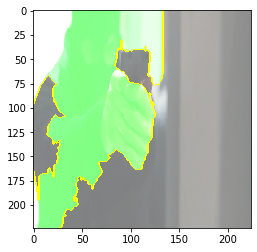

In [14]:
normal_model = get_conv_model_normal()
normal_model.load_weights('../models/CNN-ModelCheckpointWeights.h5')
img = get_image_value('../Assault_Rifle_722_33.jpg')

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(img, normal_model.predict, top_labels = 5, hide_color = 0, 
                                         num_samples = 1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = False,
                                           num_features = 10, hide_rest = False)
plt.imshow(mark_boundaries(temp/2 + .5, mask))

In [5]:
normal_model = get_conv_model_normal()
normal_model.load_weights('../models/CNN-ModelCheckpointWeights.h5')
img = cv2.imread('../Assault_Rifle_722_33.jpg')
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process() 

windows = []
locations = []
for x, y, w,h in rects: 
    startx = x 
    starty = y 
    endx = x+w 
    endy = y+h 
    roi = img[starty:endy, startx:endx]
    roi = cv2.resize(roi, dsize = (224,224), interpolation = cv2.INTER_CUBIC)
    windows.append(roi)
    locations.append((startx, starty, endx, endy))
    


In [6]:
windows = np.array(windows)

predictions = normal_model.predict(windows)

In [7]:
clone = img.copy()
new_loc = [] 
new_prob = [] 
for idx, i in enumerate(predictions): 
    if i < .5: 
        continue
    startx, starty, endx, endy = locations[idx]
    cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,255,0),2)
    text = f'Weapon: {i*100}'
    cv2.putText(clone, text, (startx, y), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,255,0),2)
    new_loc.append(locations[idx])
    new_prob.append(i[0])
    
    

In [37]:
cv2.imshow('test', clone)
cv2.waitKey(0)

-1

In [8]:
# import the necessary packages
def non_max_suppression(boxes, probs, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)
    print(idxs)
    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return the indexes of only the bounding boxes to keep
    return pick

In [9]:
new_loc

[(202, 72, 259, 104),
 (160, 160, 245, 255),
 (106, 56, 198, 170),
 (0, 0, 106, 110),
 (296, 0, 363, 113),
 (193, 64, 328, 186),
 (255, 176, 308, 192),
 (206, 0, 274, 73),
 (31, 0, 112, 95),
 (193, 80, 328, 181),
 (185, 79, 329, 183),
 (0, 0, 405, 255),
 (205, 71, 285, 97),
 (237, 0, 321, 75),
 (301, 38, 325, 60),
 (186, 154, 224, 176),
 (264, 49, 353, 102),
 (0, 73, 48, 112),
 (106, 22, 285, 170),
 (0, 0, 103, 105),
 (191, 24, 326, 81),
 (0, 0, 373, 255),
 (239, 127, 327, 186),
 (175, 80, 328, 181),
 (310, 138, 362, 234),
 (260, 158, 337, 236),
 (186, 0, 379, 255),
 (0, 0, 362, 255),
 (241, 40, 323, 70),
 (146, 78, 331, 185),
 (0, 0, 240, 255),
 (204, 161, 260, 183),
 (242, 42, 322, 70),
 (193, 80, 328, 186),
 (0, 0, 363, 255),
 (197, 162, 277, 185),
 (176, 116, 308, 192),
 (87, 0, 107, 33),
 (239, 127, 327, 187),
 (30, 0, 111, 95),
 (0, 73, 48, 115),
 (284, 74, 329, 101),
 (30, 0, 110, 92),
 (238, 0, 364, 126),
 (0, 53, 63, 109),
 (274, 41, 331, 90),
 (0, 81, 33, 115),
 (186, 145, 26

In [10]:
boxids = non_max_suppression(np.array(new_loc), np.array(new_prob))[0]
boxids

[ 97 199 268 196 170 198 171 172 173 174 175 176 177 178 179 180 181 182
 169 184 185 186 187 188 189 190 191 192 193 194 195 197 183 168 166 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 167 200 201 202 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 236 251 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 252 136 235 233 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 234 217 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 218 135   0 133  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  34  33  32  31   1   2   3   4   5   6   7   8   9  10  11
  12  13  14  64  15  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  16  65  66  67 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 102 117 119 120 121 122 123 124 125 126 127 128 129 130 131 132 118
 267 101  99  68  69  70  71  72  73  74  75  76  7

134

In [ ]:
clone = img.copy()
  
startx, starty, endx, endy = new_loc[268]
cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,255,0),2)
text = f'Weapon: {i*100}'
cv2.putText(clone, text, (startx, y), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,255,0),2)
cv2.imshow('test', clone)
cv2.waitKey(0)